# Подключение библиотек

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils 
from google.colab import files
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image 
import numpy as np 
from sklearn.model_selection import train_test_split
import time
import random
import os 
from PIL import Image 

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/База картинок/stroyka.zip'

# Загрузка изображений



In [ ]:
train_dir='Тренировочная_стройка'
val_dir='Проверочная_стройка'
image_dir='/Исходники/'
segment_dir='/Размеченные/' 
img_w=176
img_h=240
num_classes=7

In [ ]:
def color2index(color):
  index=-1
  if (149>=color[0]>51)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=0 # пол
  elif (49>=color[0]>=0)and(49>=color[1]>=0)and(149>=color[2]>=51) : index=1 # потолок
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(49>=color[2]>=0) : index=2 # стена
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(49>=color[2]>=0) : index=4 # колонна
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=3 # проем
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(149>=color[2]>=51) : index=3 # дверь
  elif (149>=color[0]>=51)and(149>=color[1]>=51)and(49>=color[2]>=0) : index=3 # окно
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=4 # внешний мир
  elif (49>=color[0]>=0)and(49>=color[1]>=51)and(249>=color[2]>=151) : index=4 # лестница
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(49>=color[2]>=0) : index=4 # перила
  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(49>=color[2]>=0) : index=4 # батарея
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=5 # люди
  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(249>=color[2]>=151) : index=4 # инвентарь
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(49>=color[2]>=0) : index=4 # источники света
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(249>=color[2]>=151) : index=4 # провода
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(249>=color[2]>=151) : index=4 # балка
  else: index=6
  return index  

In [ ]:
def load_data(x,y): # функция загрузки данных
  data_set=[] # создаем лист из картинок 
  for filename in sorted(os.listdir(x+y)):
    data_set.append(image.load_img(os.path.join(x+y+filename),target_size=(img_w,img_h)))
  data_size=[] # создаем 3 мерный массив с размерами картинок
  for img in data_set:
    input=image.img_to_array(img) # если картинка, то помещаем ее размеры в массив 
    if y == '/Исходники/':
      data_size.append(input)
    else:
      input_copy=input.copy() 
      input=input.reshape(input.shape[0] * input.shape[1], 3)
      temporary=[]
      for i in range(len(input)):
        temporary.append(utils.to_categorical(color2index(input[i]), num_classes=7)) 
      temporary=np.array(temporary)
      temporary=temporary.reshape(input_copy.shape[0],input_copy.shape[1],7) 
      data_size.append(temporary)  # если сегмент, то прогоняем ее размеры через преобразователь и помещаем их в массив 
  data_size=np.array(data_size)
  return data_size

In [ ]:
# функция создания выборки
x_train=load_data(train_dir,image_dir)
x_val=load_data(val_dir,image_dir)
y_train=load_data(train_dir,segment_dir)
y_val=load_data(val_dir,segment_dir)          

In [ ]:
print(x_train.shape) #Тренировочная_стройка/Исходники/Img_859.jpg
print(x_val.shape) #Проверочная_стройка/Исходники/Img_901.jpg
print(y_train.shape) #Тренировочная_стройка/Размеченные/Img_862 копия.bmp
print(y_val.shape) #Проверочная_стройка/Размеченные/Img_903 копия.bmp

(900, 176, 240, 3)
(50, 176, 240, 3)
(900, 176, 240, 7)
(50, 176, 240, 7)


# Визуализация результатов 



In [ ]:
def index2color(index2):
  index = np.argmax(index2)
  color=[]
  if index == 0: color = [100, 100, 100]  # пол
  elif index == 1: color = [0, 0, 100]  # потолок
  elif index == 2: color = [0, 100, 0]  # стена
  elif index == 3: color = [100, 0, 0]  # проем, дверь, окно
  elif index == 4: color = [0, 100, 100]  # колонны
  elif index == 5: color = [100, 0, 100]  # люди
  elif index == 6: color = [0, 0, 0]  # остальное
  return color

In [ ]:
def processImage(model, count = 1, n_classes = 6):
  indexes = np.random.randint(0, len(x_val), count) 
  fig, axs = plt.subplots(3, count, figsize=(25, 5))
  for i,idx in enumerate(indexes): 
    predict = np.array(model.predict(x_val[idx].reshape(1, img_w, img_h, 3))) 
    pr = predict[0] 
    pr1 = [] 
    pr2 = [] 
    pr = pr.reshape(-1, n_classes) 
    yr = y_val[idx].reshape(-1, n_classes) 
    for k in range(len(pr)):
      pr1.append(index2color(pr[k])) 
      pr2.append(index2color(yr[k])) 
    pr1 = np.array(pr1) 
    pr1 = pr1.reshape(img_w, img_h,3) 
    pr2 = np.array(pr2) 
    pr2 = pr2.reshape(img_w, img_h,3)
    img = Image.fromarray(pr1.astype('uint8')) 
    axs[0,i].imshow(img.convert('RGBA')) 
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) 
    axs[2,i].imshow(Image.fromarray(x_val[idx].astype('uint8')))   
  plt.show()  

#PSPNet 

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [ ]:
def PSP(num_classes = 3, input_shape= (176, 240, 3)):
  img_input = Input(input_shape)     
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x) # исходный шейп

  block_1_out = MaxPooling2D((2,2))(x) # TensorShape([None, 44, 60, 32])
  block_2_out = MaxPooling2D((4,4))(x) # TensorShape([None, 22, 30, 32])
  block_3_out = MaxPooling2D((8,8))(x) # TensorShape([None, 11, 15, 32])

  block_1_out=Conv2D(64,(3,3),padding='same',name='block2_conv1')(block_1_out)
  block_1_out = Activation('relu')(block_1_out)
  block_2_out=Conv2D(64,(3,3),padding='same',name='block2_conv2')(block_2_out)
  block_2_out = Activation('relu')(block_2_out)
  block_3_out=Conv2D(64,(3,3),padding='same',name='block2_conv3')(block_3_out)
  block_3_out = Activation('relu')(block_3_out)

  block_1_out=Conv2DTranspose(64,(3,3),strides=(2,2),padding='same')(block_1_out)
  block_1_out = Activation('relu')(block_1_out) 
  block_2_out=Conv2DTranspose(64,(3,3),strides=(4,4),padding='same')(block_2_out)
  block_2_out = Activation('relu')(block_2_out)
  block_3_out=Conv2DTranspose(64,(3,3),strides=(8,8),padding='same')(block_3_out)
  block_3_out = Activation('relu')(block_3_out)

  conc = concatenate([block_1_out, block_2_out, block_3_out]) 

  out=Conv2D(num_classes,(3,3),activation='softmax',padding='same')(conc)

  model = Model(img_input, out)

  model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])

  return model

In [ ]:
modelPSP = PSP(num_classes, (img_w, img_h, 3)) 

In [ ]:
train = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data = (x_val, y_val)) 

Epoch 1/5
29/29 [==============================] - 887s 30s/step - loss: 1.8645 - dice_coef: 0.3343 - val_loss: 1.3774 - val_dice_coef: 0.3186
Epoch 2/5
29/29 [==============================] - 777s 27s/step - loss: 1.2914 - dice_coef: 0.3695 - val_loss: 1.3427 - val_dice_coef: 0.3622
Epoch 3/5
29/29 [==============================] - 829s 29s/step - loss: 1.2345 - dice_coef: 0.3935 - val_loss: 1.3379 - val_dice_coef: 0.3402
Epoch 4/5
29/29 [==============================] - 870s 30s/step - loss: 1.2123 - dice_coef: 0.4004 - val_loss: 1.3312 - val_dice_coef: 0.3806
Epoch 5/5
29/29 [==============================] - 816s 28s/step - loss: 1.1847 - dice_coef: 0.4114 - val_loss: 1.3722 - val_dice_coef: 0.3893


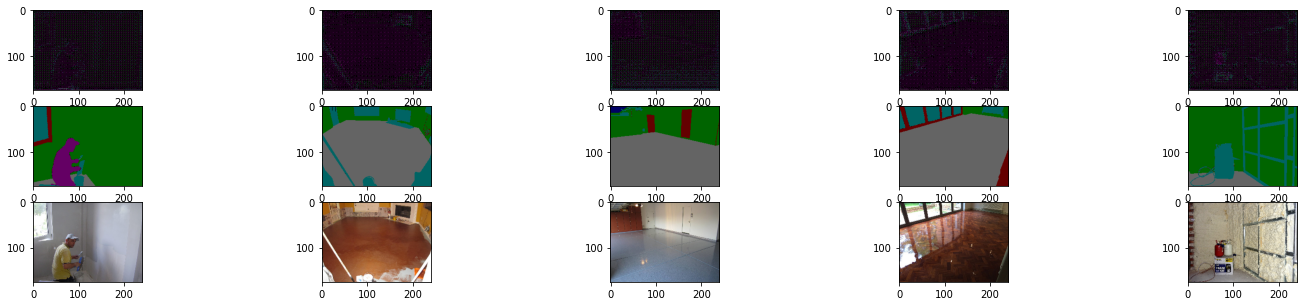

In [ ]:
# функция распознавания - на вход модель и функци имейдж 
processImage(modelPSP, 5, num_classes)